In [1]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1269.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/623.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/820.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1354.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/45.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/369.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1711.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1173.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1488.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/436.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1409.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/71.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1055.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/215.jpg
/

In [2]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet import ResNet50
from keras import backend as K

In [3]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [4]:
folder_benign_train = './data/train/benign'
folder_malignant_train = './data/train/malignant'

folder_benign_test = './data/test/benign'
folder_malignant_test = './datsa/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

In [5]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [6]:
X_train = X_train/255.
X_test = X_test/255.

In [7]:
from keras.applications.mobilenet_v2 import MobileNetV2

2022-07-19 15:37:50.671636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 15:37:50.814870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 15:37:50.815663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 15:37:50.817091: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/50


2022-07-19 15:38:02.477829: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 - 24s - loss: 0.6625 - accuracy: 0.6302 - val_loss: 0.6928 - val_accuracy: 0.5360
Epoch 2/50
33/33 - 10s - loss: 0.6255 - accuracy: 0.6790 - val_loss: 0.6925 - val_accuracy: 0.5360
Epoch 3/50
33/33 - 10s - loss: 0.5979 - accuracy: 0.6837 - val_loss: 0.6922 - val_accuracy: 0.5360
Epoch 4/50
33/33 - 10s - loss: 0.5524 - accuracy: 0.7312 - val_loss: 0.6919 - val_accuracy: 0.5360
Epoch 5/50
33/33 - 10s - loss: 0.5074 - accuracy: 0.7549 - val_loss: 0.6917 - val_accuracy: 0.5360
Epoch 6/50
33/33 - 10s - loss: 0.4730 - accuracy: 0.7743 - val_loss: 0.6915 - val_accuracy: 0.5360
Epoch 7/50
33/33 - 10s - loss: 0.4501 - accuracy: 0.7909 - val_loss: 0.6912 - val_accuracy: 0.5360
Epoch 8/50
33/33 - 11s - loss: 0.4275 - accuracy: 0.7985 - val_loss: 0.6911 - val_accuracy: 0.5360
Epoch 9/50
33/33 - 10s - loss: 0.4269 - accuracy: 0.7985 - val_loss: 0.6910 - val_accuracy: 0.5360
Epoch 10/50
33/33 - 10s - loss: 0.4188 - accuracy: 0.7942 - val_loss: 0.6909 - val_accuracy: 0.5360
Epoch 11/50
33/33 - 

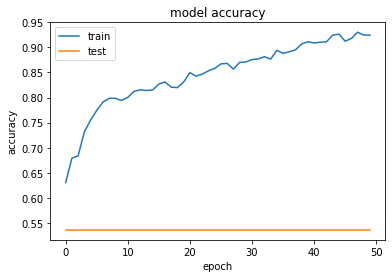

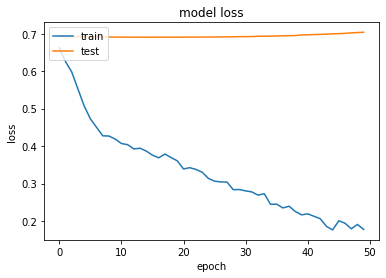

In [8]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = MobileNetV2(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()